# Imports

In [1]:
from scipy.stats import *
from scipy.special import *
import numpy as np
import matplotlib.pyplot as plt
import copy

# Plot methods

In [2]:
def draw_ellipse(position, covariance, cm, label, ax=None, **kwargs):
# def draw_ellipse(position, covariance, ax=None, **kwargs):
    from matplotlib.patches import Ellipse
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    plt.plot()
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, facecolor=cm(label), alpha=0.8*1/nsig))

def plot_gmm_approx(elbos, mk, wk_inv, vk, figsize=(10,20)):
    f, ax =plt.subplots(1, 2, figsize=figsize)
    for i in range(n_mixtures):
        precision = e_lambda(wk_inv, vk, i)
        cov = np.linalg.inv(precision)

        ax[0].scatter(samples[i][:, 0], samples[i][:,1], label=i)
        ax[0].scatter(mk[i, 0], mk[i, 1], c='black')
        cm = plt.cm.get_cmap('viridis_r', 7)
        draw_ellipse(mk[i, :], cov, cm, i, ax=ax[0])
    ax[1].plot(range(len(elbos)), elbos)
    plt.show()

# Evidence Lower Bound 

In [20]:
# ELBO  
def log_e(x):
    return np.log(x+np.finfo(np.float32).eps)

def compute_elbo(alphak, alphao, r_probs, mk, bk, mo, bo, vk, wk_inv, vo, wo_inv, data):
    D, n_data = data.shape
    n_mixtures = mk.shape[0]
    
    p_x_given_z = p_m_l = p_pi = p_z = q_m_l = q_pi = q_z = 0
    
    q_z = np.sum(r_probs*np.log(r_probs))

    q_pi = -(np.sum(gammaln(alphak)) - gammaln(np.sum(alphak)))
    for k in range(n_mixtures):
        q_pi += (alphak[k]-1)*e_pi_log(alphak, k)

    q_m_l = 0
    for k in range(n_mixtures):
        q_m_l += -.5*D*np.log(2*np.pi) + .5*D*np.log(bk[k]) + .5*e_lambda_log_det(vk, wk_inv, k)
        q_m_l += wishart_log_norm_const(vk[k], np.linalg.inv(wk_inv[k,:,:]))
        q_m_l += -.5*D +.5*(vk[k]-D-1)*e_lambda_log_det(vk, wk_inv, k)
        q_m_l += -.5*vk[k]*D
        
    p_z = 0
    for n in range(n_data):
        for k in range(n_mixtures):
            p_z+= r_probs[k,n]*e_pi_log(alphak, k)

    p_pi = -(np.sum(gammaln(alphao+ np.finfo(np.float32).eps)) - gammaln(np.sum(alphao+ np.finfo(np.float32).eps)))
    for k in range(n_mixtures):
        p_pi += (alphao[k]-1)*e_pi_log(alphak, k)

    p_m_l = 0
    for k in range(n_mixtures):
        m = mk[k, :] - mo[k, :]
        wo = np.linalg.inv(wo_inv[k,:,:])
        aux = (bo[k]*D/bk[k]) + bo[k]*np.dot(m.T, np.dot(e_lambda(wk_inv, vk, k), m))
        p_m_l += -.5*D*np.log(2*np.pi) + .5*(D*np.log(bo[k]) + e_lambda_log_det(vk, wk_inv, k)) -.5*aux 
        p_m_l += wishart_log_norm_const(vo[k], wo)
        p_m_l += +.5*(vo[k]-D-1)*e_lambda_log_det(vk, wk_inv, k) -.5*np.trace(np.dot(wo_inv[k,:,:], e_lambda(wk_inv, vk, k)))
    
    p_x_given_z = 0
    for n in range(n_data):
        for k in range(n_mixtures):
            xn = data[:, n]
            m = xn - mk[k, :]
            aux = D/bk[k] + np.dot(m.T, np.dot(e_lambda(wk_inv, vk, k), m))
            p_x_given_z += r_probs[k,n]*(-.5*D*np.log(2*np.pi) + .5*e_lambda_log_det(vk, wk_inv, k) -.5*aux)

    elbo = p_x_given_z + p_m_l + p_pi + p_z - (q_m_l + q_pi + q_z)
    return elbo

# Auxiliar functions

In [4]:
def wishart_log_norm_const(v, w):
    D = w.shape[1]
    aux = 0
    for j in range(1, D+1):
        aux += gammaln(.5*v -.5*(j-1))
    multi_gamma = (D*(D-1)/4)*np.log(np.pi) + aux
    return -.5*v*D*np.log(2) -.5*v*np.log(np.linalg.det(w))-multi_gamma

def softmax(unnormalized):
    e_x = np.exp(unnormalized - np.max(unnormalized))
    return (e_x+np.finfo(np.float32).eps) / (e_x.sum()+np.finfo(np.float32).eps)

def e_pi_log(alphak, k):
    return psi(alphak[k] + np.finfo(np.float32).eps) - psi(np.sum(alphak))

def e_lambda_log_det(vk, wk_inv, k):
    D = wk_inv.shape[1]
    wk = np.linalg.inv(wk_inv[k, :, :])
    det_wk = np.linalg.det(wk)
    sum_psi = 0
    for i in range(1, D+1):
        sum_psi += psi((vk[k]+1-i)/2.0) 
    return sum_psi + float(D)*np.log(2) + np.log(det_wk)

def e_lambda(wk_inv, vk, k):
    wk = np.linalg.inv(wk_inv[k, :, :])
    return vk[k]*wk

def dirichlet_expectation(alphak):
    return alphak/np.sum(alphak)

# Update for variational parameters

In [5]:
def update_r_z(r_probs, alphak, mk, bk, vk, wk_inv, data):
    D, n_data = data.shape
    n_mixtures = r_probs.shape[0]
    for n in range(n_data):
        rho_n = np.zeros((n_mixtures)) 
        for k in range(n_mixtures):
            xn = data[:, n]
            m = xn - mk[k,:]
            wk = np.linalg.inv(wk_inv[k,:,:])
            aux = D/bk[k] + vk[k]*np.dot(np.dot(m.T, wk), m)
            rho_n[k] = -(D/2.)*np.log(2*np.pi) + e_pi_log(alphak, k) + .5*e_lambda_log_det(vk, wk_inv, k) - .5*aux
        r_probs[:, n] = softmax(rho_n)
    return r_probs


def update_alphak_pi(alphak, alphao, r_probs):
    n_mixtures = alphak.shape[0]
    for k in range(n_mixtures):
        alphak[k] = alphao[k] + np.sum(r_probs[k, :])
    return alphak
            
    
def update_mk_mean(mk, mo, bo, bk, r_probs, data):
    D, n_data = data.shape
    n_mixture = mk.shape[0]
    for k in range(n_mixture):
        aux = np.zeros((D))
        for n in range(n_data):
            x_n = data[:,n]
            aux += r_probs[k, n]*x_n
        mk[k, :] = (mo[k, :]*bo[k] + aux)/bk[k]
    return mk

def update_bk_mean(bk, bo, r_probs):
    n_mixture = bk.shape[0]
    for k in range(n_mixture):
        bk[k] = bo[k] + np.sum(r_probs[k, :])
    return bk

def update_vk_lambda(vk, vo, r_probs):
    n_mixture = vk.shape[0]
    for k in range(n_mixtures):
        vk[k] = vo[k] + np.sum(r_probs[k, :])
    return vk
            
def update_wk_inv_lambda(wk_inv, wo_inv, mk, mo, bk, bo, r_probs, data):
    n_mixtures = wk_inv.shape[0]
    D, n_data = data.shape
    for k in range(n_mixtures):
        aux = np.zeros((D, D))
        for n in range(n_data):
            x_n = data[:,n]
            aux += r_probs[k, n]*np.outer(x_n,x_n.T)
        wk_inv[k,:,:] = wo_inv[k, :, :]
        wk_inv[k,:,:] +=  bo[k]*np.outer(mo[k,:], mo[k,:].T)
        wk_inv[k,:,:] += -bk[k]*np.outer(mk[k,:], mk[k,:].T)
        wk_inv[k,:,:] +=  aux
    return wk_inv


# Data

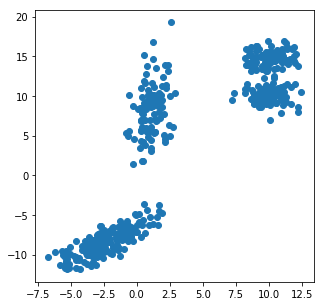

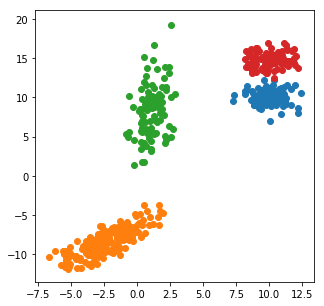

In [6]:
a = np.array([[3,2.5],[2.5,3]])
b = np.array([[.8,1],[1,10]])
# Prepare dataset
g1 = multivariate_normal(mean=[10, 10], cov=1)
g2 = multivariate_normal(mean=[-2, -8], cov=a)
g3 = multivariate_normal(mean=[1, 8], cov=b)
g4 = multivariate_normal(mean=[10, 15], cov=1)

samples = list()
samples.append(g1.rvs(100))
samples.append(g2.rvs(200))
samples.append(g3.rvs(100))
samples.append(g4.rvs(100))

data = np.vstack(samples)
data = data.T
data.shape

plt.figure(figsize=(5,5))
plt.scatter(data[0,:], data[1,:])
plt.show()
plt.figure(figsize=(5,5))
for sample in samples:
    plt.scatter(sample[:, 0], sample[:,1])

# Run optimization, maximize ELBO

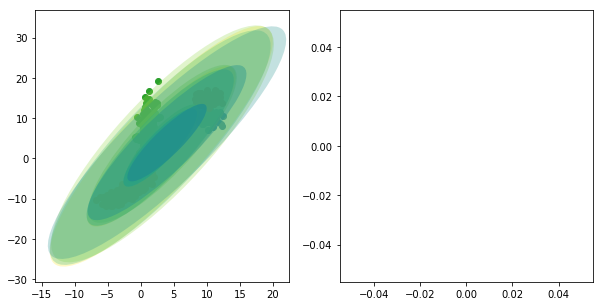

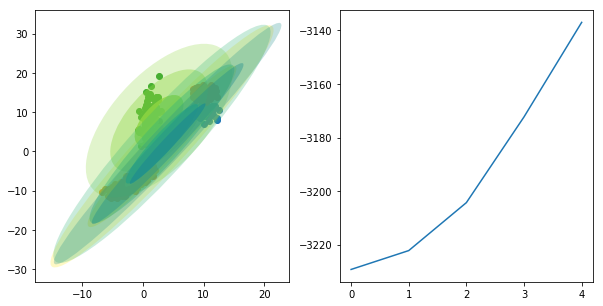

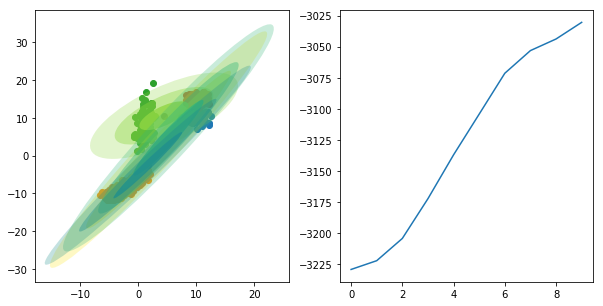

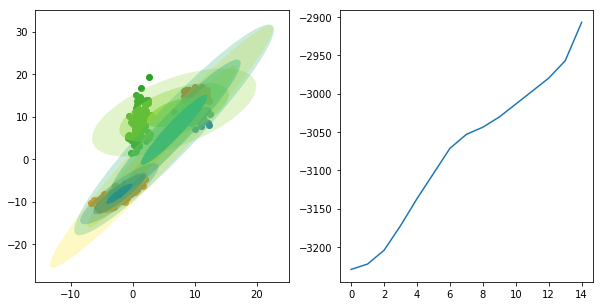

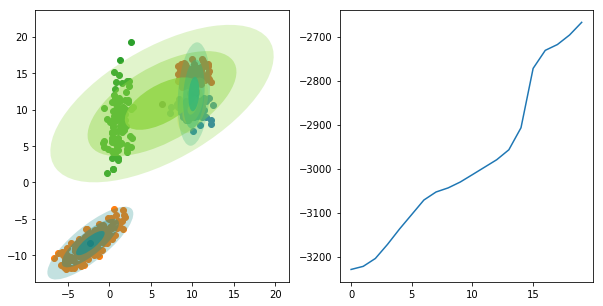

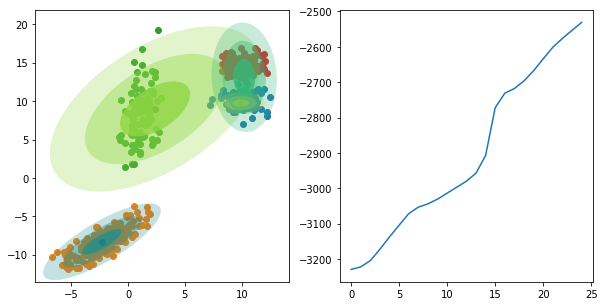

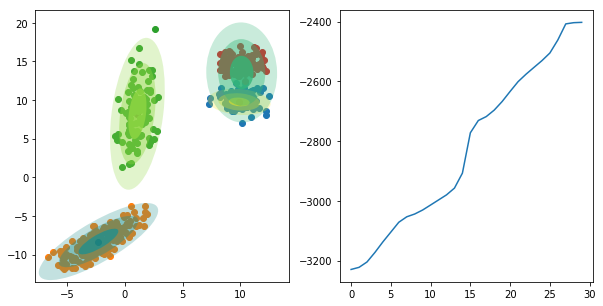

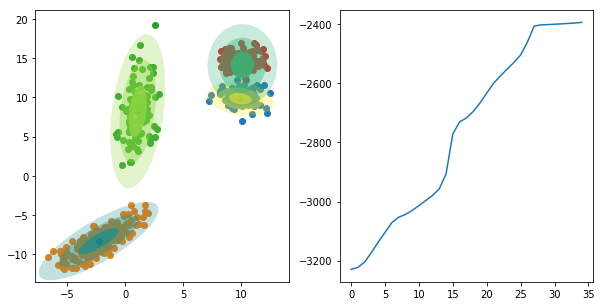

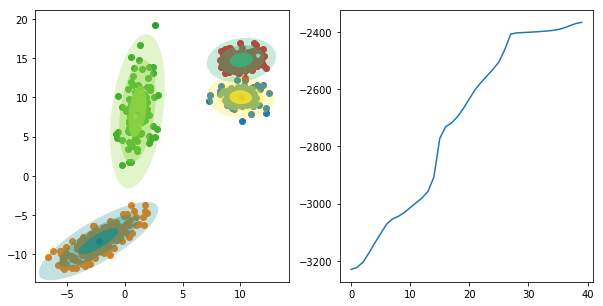

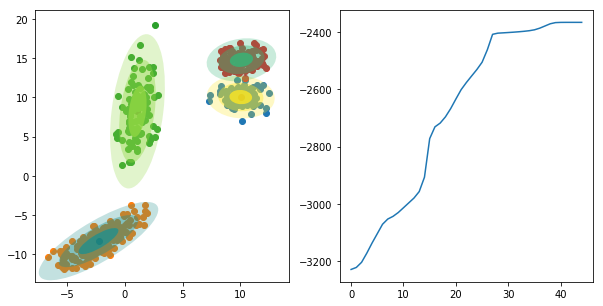

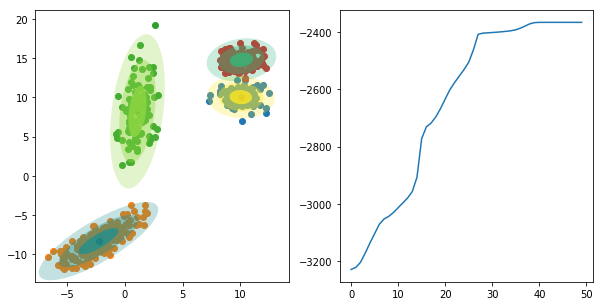

Converged


In [17]:
dimensionality = 2
n_mixtures = 4
n_data = data.shape[1]

## Priors 
# Pi Dirichlet.
alphao = np.ones((n_mixtures), dtype=np.float64)*0.1

# Mean distribution.
mo = np.ones((n_mixtures, dimensionality), dtype=np.float64)*10
bo = 0.01*np.ones((n_mixtures), dtype=np.float64)

# Precision distribution.
vo = (dimensionality + 1)*np.ones((n_mixtures), dtype=np.float64)
wo_inv = np.zeros((n_mixtures, dimensionality, dimensionality), dtype=np.float64)
for k in range(n_mixtures):
    aux = np.random.rand(dimensionality, dimensionality)
    wo_inv[k,:,:] = np.dot(aux, aux.transpose())
    
## Inital values approximation parameters.
# Pi Dirichlet.
alphak = np.zeros((n_mixtures), dtype=np.float64)

# Z r_probs.
r_probs = np.random.dirichlet([0.1]*n_mixtures, n_data).T

# Mean distribution.
mk = np.zeros((n_mixtures, dimensionality), dtype=np.float64)
bk = np.zeros((n_mixtures), dtype=np.float64)

# Precision distribution.
vk = (dimensionality + 1)*np.ones((n_mixtures), dtype=np.float64)
wk_inv = np.zeros((n_mixtures, dimensionality, dimensionality), dtype=np.float64)
for k in range(n_mixtures):
    wk_inv[k,:,:] = np.eye(dimensionality)
    
elbos = list()
# Update parameters to maximize ELBO
for update in range(100): 
    
    alphak = update_alphak_pi(alphak, alphao, r_probs)
    bk = update_bk_mean(bk, bo, r_probs)
    vk = update_vk_lambda(vk, vo, r_probs)
    mk = update_mk_mean(mk, mo, bo, bk, r_probs, data)
    wk_inv = update_wk_inv_lambda(wk_inv, wo_inv, mk, mo, bk, bo, r_probs, data)    
    r_probs = update_r_z(r_probs, alphak, mk, bk, vk, wk_inv, data)
    current_elbo = compute_elbo(alphak, alphao, r_probs, mk, bk, mo, bo, vk, wk_inv, vo, wo_inv, data)
    if update!=0 and current_elbo-prev_elbo < 1e-12: 
        print('Converged')
        break
    if update%5 == 0:
        plot_gmm_approx(elbos, mk, wk_inv, vk, figsize=(10,5))
    elbos.append(current_elbo)
    prev_elbo = current_elbo


Gaussian 0
	Mean:
		 [10.03287176 10.04308486]
	Covariance:
		 [ 0.96112799 -0.05433757]
		 [-0.05433757  0.82047739]

Gaussian 1
	Mean:
		 [1.08243008 8.22713287]
	Covariance:
		 [0.62731166 0.84236744]
		 [ 0.84236744 10.74047139]

Gaussian 2
	Mean:
		 [10.09186428 14.79359291]
	Covariance:
		 [1.01026309 0.14561399]
		 [0.14561399 0.83395072]

Gaussian 3
	Mean:
		 [-2.29271341 -8.31407598]
	Covariance:
		 [2.9779267  2.30894456]
		 [2.30894456 2.76738151]


Pi (Gaussian weights): [0.19986723 0.20012445 0.20021276 0.39979557]


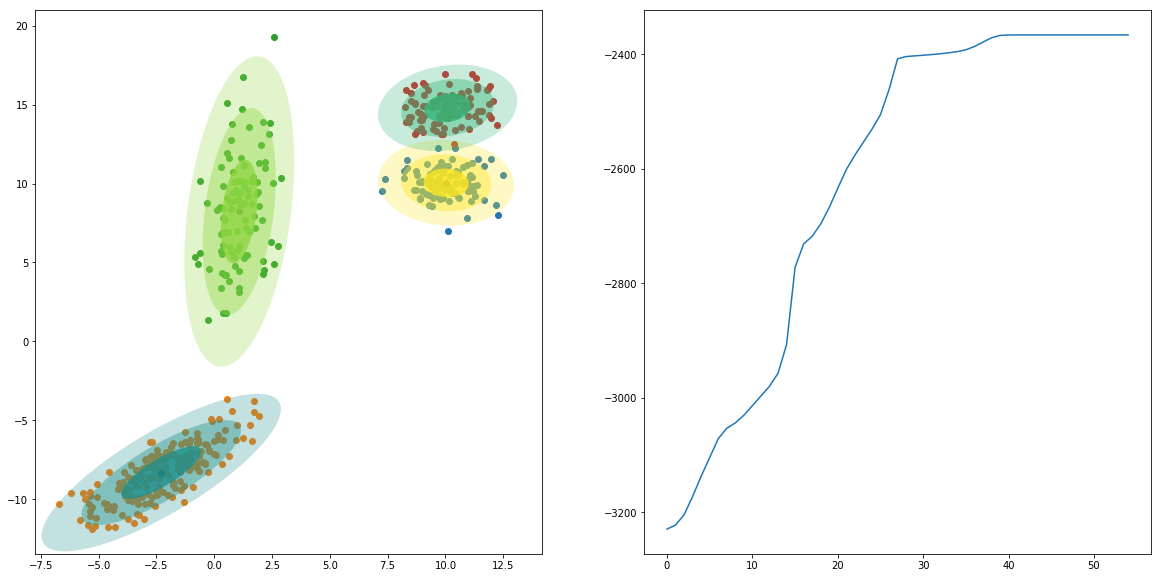

In [19]:
for i in range(n_mixtures):
    print('Gaussian', i)
    precision = e_lambda(wk_inv, vk, i)
    cov = np.linalg.inv(precision)
    print('\tMean:')
    print('\t\t', mk[i, :])
    print('\tCovariance:')
    print('\t\t', cov[0, :])
    print('\t\t', cov[1, :])
    print()
print()
print('Pi (Gaussian weights):', dirichlet_expectation(alphak)[:])

plot_gmm_approx(elbos, mk, wk_inv, vk, figsize=(20,10))